In [1]:
# from deepcell.datasets import TissueNet
import os
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import matplotlib.pyplot as plt
import time

from tqdm import tqdm

from temp_panoptic import PanopticNet
from temp_mesmer import Mesmer

from deepcell.applications.mesmer import mesmer_preprocess
from deepcell import image_generators

In [2]:
torch.cuda.empty_cache()
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device_ids = [0, 1]
print(device)

cuda:1


In [3]:
# # Only use if saved data gets deleted
# tissuenet = TissueNet(version='1.1')
# X_train, y_train, meta_train = tissuenet.load_data(split='train')
# X_val, y_val, meta_val = tissuenet.load_data(split='val')
# X_test, y_test, meta_test = tissuenet.load_data(split='test')

In [4]:
tissuenet_dir = "/data/tissuenet"
if not os.path.exists(tissuenet_dir):
    print("Created tissuenet data dir")
    os.makedirs(tissuenet_dir)

print(os.listdir("/data"))
print(os.listdir(tissuenet_dir))

['saved_model_dict.pth', 'saved_model.pth', 'saved_model_full.pth', 'saved_model_full_epoch10.pth', 'saved_model_full_epoch20.pth', 'saved_model_full_epoch30.pth', 'saved_model_full_gen_16_epoch20.pth', 'saved_model_full_gen_16_epoch30.pth', 'saved_model_40.pth', 'saved_model_40_epoch10.pth', 'saved_model_40_epoch20.pth', 'saved_model_40_epoch30.pth', 'saved_model_full_gen_8.pth', 'saved_model_full_gen_8_epoch20.pth', 'saved_model_full_gen_8_epoch40.pth', 'tissuenet', 'saved_model_full_gen.pth', 'saved_model_full_gen_epoch10.pth', 'saved_model_full_gen_epoch20.pth', 'saved_model_full_gen_epoch30.pth', 'saved_model_full_gen_epoch40.pth', 'saved_model_full_gen_epoch50.pth', 'saved_model_full_gen_epoch60.pth', 'saved_model_full_gen_epoch70.pth', 'saved_model_full_gen_epoch80.pth', 'saved_model_full_gen_epoch90.pth', 'saved_model_full_gen_epoch100.pth', 'saved_model_full_gen_16.pth', 'saved_model_full_gen_16_epoch10.pth', 'saved_model_full_gen_8_epoch10.pth', 'saved_model_full_gen_8_epoch3

In [5]:
def load_data(filepath):
    """Load train, val, and test data"""
    X_train, y_train = _load_npz(os.path.join(filepath, "train.npz"))

    X_val, y_val = _load_npz(os.path.join(filepath, "val_256x256.npz"))

    return (X_train, y_train), (X_val, y_val)

In [6]:
def _load_npz(filepath):
    """Load a npz file"""
    data = np.load(filepath)
    X = data["X"]
    y = data["y"]

    print(
        "Loaded {}: X.shape: {}, y.shape {}".format(
            os.path.basename(filepath), X.shape, y.shape
        )
    )

    return X, y

In [7]:
from deepcell_toolbox.metrics import Metrics
from scipy.stats import hmean


def evaluate(y_pred, y_test):
    m = Metrics("DVC Mesmer")
    metrics = m.calc_object_stats(y_test, y_pred)

    # calculate image-level recall and precision for F1 score
    recall = metrics["correct_detections"].values / metrics["n_true"].values
    recall = np.where(np.isfinite(recall), recall, 0)

    precision = metrics["correct_detections"] / metrics["n_pred"]
    precision = np.where(np.isfinite(precision), precision, 0)
    f1 = hmean([recall, precision])

    # record summary stats
    summary = m.summarize_object_metrics_df(metrics)

    valid_keys = {
        "recall",
        "precision",
        "jaccard",
        "n_true",
        "n_pred",
        "gained_detections",
        "missed_detections",
        "split",
        "merge",
        "catastrophe",
    }

    output_data = {}
    for k in valid_keys:
        if k in {"jaccard", "recall", "precision"}:
            output_data[k] = float(summary[k])
        else:
            output_data[k] = int(summary[k])
    output_data["f1"] = float(np.mean(f1))

    return output_data


In [8]:
def weighted_categorical_crossentropy(y_true, y_pred,
                                      n_classes=3, axis=None,
                                      from_logits=False):
    """Categorical crossentropy between an output tensor and a target tensor.
    Automatically computes the class weights from the target image and uses
    them to weight the cross entropy

    Args:
        y_true: A tensor of the same shape as ``y_pred``.
        y_pred: A tensor resulting from a softmax
            (unless ``from_logits`` is ``True``, in which
            case ``y_pred`` is expected to be the logits).
        from_logits: Boolean, whether ``y_pred`` is the
            result of a softmax, or is a tensor of logits.

    Returns:
        tensor: Output tensor.
    """
    if from_logits:
        raise Exception('weighted_categorical_crossentropy cannot take logits')
    y_true = torch.tensor(y_true).to(device)
    # y_true = K.cast(y_true, y_pred.dtype)
    # n_classes = K.cast(n_classes, y_pred.dtype)
    if axis is None:
        axis = 1 # if K.image_data_format() == 'channels_first' else K.ndim(y_pred) - 1
    reduce_axis = [x for x in list(range(torch.Tensor.dim(y_pred))) if x != axis]
    # scale preds so that the class probas of each sample sum to 1
    y_pred = y_pred / torch.sum(y_pred, dim=axis, keepdims=True)
    # manual computation of crossentropy
    eps=1e-10
    _epsilon = torch.tensor(eps).type(y_pred.dtype).to(device)#.base_dtype)
    y_pred = torch.clamp(y_pred, min=_epsilon, max=(1. - _epsilon))
    total_sum = torch.sum(y_true)
    class_sum = torch.sum(y_true, dim=reduce_axis, keepdims=True)
    class_weights = 1.0 / n_classes * torch.divide(total_sum, class_sum + 1.)
    return - torch.sum((y_true * torch.log(y_pred) * class_weights), dim=axis)


In [9]:
def semantic_loss(n_classes, device):
    def _semantic_loss(y_pred, y_true):
        # assert(list(y_pred.size())==list(y_true.shape))
        if n_classes > 1:
            tmp_loss = 0.01 * weighted_categorical_crossentropy(y_true, y_pred, n_classes=n_classes)
            return torch.mean(tmp_loss)
        else:
            loss = nn.MSELoss()
            tmp_loss = loss(y_pred, torch.Tensor(y_true).to(device))
            return tmp_loss

    return _semantic_loss

In [10]:
def create_model(input_shape=(256, 256, 2), backbone="resnet50", lr=1e-4):
    model = PanopticNet(
        backbone=backbone,
        input_shape=input_shape,
        norm_method=None,
        num_semantic_heads=4,
        num_semantic_classes=[
            1,
            3,
            1,
            3,
        ],  # inner distance, pixelwise, inner distance, pixelwise
        location=True,  # should always be true
        include_top=True,
        device=device,
    )
    print(device)

    loss = []
    model = model.to(device)
    temp_input = torch.Tensor(np.random.rand(4, 2, 256, 256)).to(device)
    for m in model.model_li:
        n_classes = m(temp_input).shape[1]
        print(n_classes)
        loss.append(semantic_loss(n_classes, device))

    # optimizer = Adam(lr=lr, clipnorm=0.001)
    # Figure out how to clipnorm

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # model.compile(loss=loss, optimizer=optimizer)

    # print(summary(model, input_size=(4, 2, 256, 256)))

    return model, loss, optimizer

In [11]:
# instantiate model
crop_size = 256
backbone = 'resnet50'
lr = 0.0001
model, losses, optimizer = create_model(
    input_shape=(crop_size, crop_size, 2),
    backbone=backbone,
    lr=lr,
)
count = 0
for module in model.modules():
    if isinstance(module, torch.nn.modules.BatchNorm2d):
        count+=1
        # module.track_running_stats=False
print(count)
count = 0
for module in model.modules():
    if isinstance(module, torch.nn.modules.Dropout):
        count+=1
print(count)
count = 0
for module in model.modules():
    if isinstance(module, torch.nn.Dropout):
        count+=1
print(count)

channels_first
Using ImageNet
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
size of all 5
['P7', 'P6', 'P5', 'P4', 'P3']
cuda:1
1
3
1
3
57
0
0


In [12]:
def create_data_generators(
    train_dict,
    val_dict,
    rotation_range=180,
    shear_range=0,
    zoom_min=0.7,
    horizontal_flip=True,
    vertical_flip=True,
    crop_size=(256, 256),
    seed=0,
    batch_size=8,
    min_objects=0,
):
    # use augmentation for training but not validation
    datagen = image_generators.CroppingDataGenerator(
        rotation_range=rotation_range,
        shear_range=shear_range,
        zoom_range=(zoom_min, 1 / zoom_min),
        horizontal_flip=horizontal_flip,
        vertical_flip=vertical_flip,
        crop_size=(crop_size, crop_size),
    )

    datagen_val = image_generators.SemanticDataGenerator(
        rotation_range=0,
        shear_range=0,
        zoom_range=0,
        horizontal_flip=0,
        vertical_flip=0,
    )

    train_data = datagen.flow(
        train_dict,
        seed=seed,
        transforms=["inner-distance", "pixelwise"],
        transforms_kwargs={
            "pixelwise": {"dilation_radius": 1},
            "inner-distance": {"erosion_width": 1, "alpha": "auto"},
        },
        min_objects=0,
        batch_size=batch_size,
    )

    val_data = datagen_val.flow(
        val_dict,
        seed=seed,
        transforms=["inner-distance", "pixelwise"],
        transforms_kwargs={
            "pixelwise": {"dilation_radius": 1},
            "inner-distance": {"erosion_width": 1, "alpha": "auto"},
        },
        min_objects=min_objects,
        batch_size=batch_size,
    )

    return train_data, val_data


In [13]:
seed = 0
zoom_min = 0.75
batch_size = 8

In [14]:
(X_train, y_train), (X_val, y_val) = load_data(tissuenet_dir)
X_test, y_test = _load_npz(os.path.join(tissuenet_dir, "test_256x256.npz"))
smaller = None
smaller_test = None

Loaded train.npz: X.shape: (2580, 512, 512, 2), y.shape (2580, 512, 512, 2)
Loaded val_256x256.npz: X.shape: (3118, 256, 256, 2), y.shape (3118, 256, 256, 2)
Loaded test_256x256.npz: X.shape: (1324, 256, 256, 2), y.shape (1324, 256, 256, 2)


In [15]:
# smaller = 40
# smaller_test = 20
if smaller:
    X_train, y_train = X_train[:smaller], y_train[:smaller]
    X_val, y_val = X_val[:smaller], y_val[:smaller]
if smaller_test:
    X_test, y_test = X_test[:smaller_test], y_test[:smaller_test]

In [16]:
train_dict = {"X": mesmer_preprocess(X_train), "y": y_train}
val_dict = {"X": mesmer_preprocess(X_val), "y": y_val}

# train_dict = {"X": X_train, "y": y_train}
# val_dict = {"X": X_val, "y": y_val}

In [17]:
print(train_dict["X"].shape)

(2580, 512, 512, 2)


In [18]:
train_data, val_data = create_data_generators(
    train_dict,
    val_dict,
    seed=seed,
    zoom_min=zoom_min,
    batch_size=batch_size,
    crop_size=crop_size,
)

In [19]:
def train_one_epoch(model):
    running_loss_avg = 0.
    count = 0

    per_epoch_steps = len(X_train)//batch_size if len(X_train)%batch_size==0 else (len(X_train)//batch_size + 1)
    for _ in tqdm(range(per_epoch_steps)):
        count += 1
        
        li_inputs, li_labels = train_data.next()
        
        inputs = np.transpose(li_inputs, (0, 3, 1, 2))
        labels = [np.transpose(l, (0, 3, 1, 2)) for l in li_labels]

        optimizer.zero_grad()
        
        outputs = model(inputs)

        loss = sum([losses[j](outputs[j], labels[j]) for j in range(len(losses))])
            
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.001, error_if_nonfinite=True)
    
        optimizer.step()

        running_loss_avg += loss.item()
        
    return running_loss_avg/count

In [20]:
# for param in model.parameters():
#     param.requires_grad=True

In [21]:
loss_tracking = []
vloss_tracking = []
decay_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
plateau_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.33, patience=5,)

In [ ]:
start = time.time()
end = time.time()

epoch_number = 0
start_epoch = 0
EPOCHS = 100

best_vloss = 1_000_000.

model = model.to(device)

save_path_prefix = "/data/saved_model"
if smaller is None:
    save_path_prefix = save_path_prefix + "_full_gen_8"
else:
    save_path_prefix = save_path_prefix + "_" + str(smaller)

for epoch in range(start_epoch, EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    print("TRAIN")
    model.train(True)
    avg_loss = train_one_epoch(model)
    count = 0
    
    running_vloss_avg = 0.
    
    print("VAL")
    model.eval()

    per_epoch_steps = len(X_val)//batch_size if len(X_val)%batch_size==0 else (len(X_val)//batch_size + 1)
    with torch.no_grad():
        for _ in tqdm(range(per_epoch_steps)):
            count += 1
            
            li_inputs, li_labels = val_data.next()

            vinputs = np.transpose(li_inputs, (0, 3, 1, 2))
            vlabels = [np.transpose(l, (0, 3, 1, 2)) for l in li_labels]
            
            voutputs = model(vinputs)
            
            vloss = sum([losses[j](voutputs[j], vlabels[j]) for j in range(len(losses))])
                
            running_vloss_avg += vloss
                
    avg_vloss = running_vloss_avg/count

    decay_scheduler.step()
    plateau_scheduler.step(avg_vloss)
    print(decay_scheduler.get_last_lr())
    
    loss_tracking.append(avg_loss)
    vloss_tracking.append(avg_vloss)
    
    # Save model periodically
    if (epoch+1)%10==0:
        epoch_path_prefix = save_path_prefix + "_epoch" + str(epoch+1)
        dict_save_path = epoch_path_prefix + "_dict.pth"
        save_path = epoch_path_prefix + ".pth"
        
        # torch.save(model.state_dict(), dict_save_path)
        torch.save(model, save_path)
    
    if avg_vloss<best_vloss:
        best_vloss = avg_vloss
        dict_save_path = save_path_prefix + "_dict.pth"
        save_path = save_path_prefix + ".pth"
        
        # torch.save(model.state_dict(), dict_save_path)
        torch.save(model, save_path)
        
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    epoch_number += 1


print("Avg epoch time", (end - start)/EPOCHS)
print("Best validation loss -", best_vloss)

EPOCH 1:
TRAIN


  0%|                                                                                                                                                                                                                                                   | 0/323 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/deepcell/utils/transform_utils.py:87: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  edge = binary_dilation(edge, selem=dil_strel)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [11:51<00:00,  2.20s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [05:19<00:00,  1.22it/s]


[9.900000000000001e-05]
LOSS train 0.04695531746643616 valid 0.031532883644104004
EPOCH 2:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [11:42<00:00,  2.17s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [05:20<00:00,  1.22it/s]


[9.801e-05]
LOSS train 0.033410273919072316 valid 0.027234697714447975
EPOCH 3:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [11:43<00:00,  2.18s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [05:24<00:00,  1.20it/s]


[9.70299e-05]
LOSS train 0.03046721987564682 valid 0.03366139903664589
EPOCH 4:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [11:41<00:00,  2.17s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [05:20<00:00,  1.22it/s]


[9.605960100000001e-05]
LOSS train 0.02850094618096994 valid 0.05883297696709633
EPOCH 5:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [11:41<00:00,  2.17s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [05:18<00:00,  1.22it/s]


[9.509900499000001e-05]
LOSS train 0.027299830286357057 valid 0.02479049563407898
EPOCH 6:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [11:40<00:00,  2.17s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [05:18<00:00,  1.23it/s]


[9.414801494010001e-05]
LOSS train 0.02619566030269806 valid 0.023217368870973587
EPOCH 7:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [11:39<00:00,  2.17s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [05:18<00:00,  1.23it/s]


[9.320653479069902e-05]
LOSS train 0.025758994224224667 valid 0.025599349290132523
EPOCH 8:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [11:37<00:00,  2.16s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [05:18<00:00,  1.22it/s]


[9.227446944279203e-05]
LOSS train 0.025289612456048976 valid 0.024215031415224075
EPOCH 9:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [11:41<00:00,  2.17s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [05:18<00:00,  1.23it/s]


[9.13517247483641e-05]
LOSS train 0.02466307079921197 valid 0.021515898406505585
EPOCH 10:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [11:38<00:00,  2.16s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [05:18<00:00,  1.23it/s]


[9.043820750088047e-05]
LOSS train 0.02434290145399862 valid 0.021517010405659676
EPOCH 11:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [11:40<00:00,  2.17s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [05:18<00:00,  1.22it/s]


[8.953382542587167e-05]
LOSS train 0.023785819662821367 valid 0.02104446105659008
EPOCH 12:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [11:38<00:00,  2.16s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [05:18<00:00,  1.22it/s]


[8.863848717161295e-05]
LOSS train 0.02384332882892052 valid 0.024266257882118225
EPOCH 13:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [11:40<00:00,  2.17s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [05:18<00:00,  1.22it/s]


[8.775210229989682e-05]
LOSS train 0.023746889254695307 valid 0.022785596549510956
EPOCH 14:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [11:38<00:00,  2.16s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [05:20<00:00,  1.22it/s]


[8.687458127689785e-05]
LOSS train 0.023574376314440194 valid 0.022659339010715485
EPOCH 15:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [11:46<00:00,  2.19s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [05:21<00:00,  1.21it/s]


[8.600583546412887e-05]
LOSS train 0.023260808330686653 valid 0.020788853988051414
EPOCH 16:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [11:45<00:00,  2.18s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [05:21<00:00,  1.21it/s]


[8.514577710948758e-05]
LOSS train 0.02293918582527169 valid 0.03153815120458603
EPOCH 17:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [11:46<00:00,  2.19s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [05:22<00:00,  1.21it/s]


[8.429431933839271e-05]
LOSS train 0.02276796994344461 valid 0.02123676985502243
EPOCH 18:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [11:45<00:00,  2.18s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [05:22<00:00,  1.21it/s]


[8.345137614500879e-05]
LOSS train 0.022789100130252978 valid 0.024124106392264366
EPOCH 19:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [11:45<00:00,  2.18s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [05:12<00:00,  1.25it/s]


[8.26168623835587e-05]
LOSS train 0.022561345165797247 valid 0.020163865759968758
EPOCH 20:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [10:23<00:00,  1.93s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [03:28<00:00,  1.87it/s]


[8.17906937597231e-05]
LOSS train 0.022427229210734367 valid 0.024284381419420242
EPOCH 21:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [10:16<00:00,  1.91s/it]


VAL


 25%|███████████████████████████████████████████████████████████▍                                                                                                                                                                              | 99/390 [00:53<02:17,  2.12it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [10:22<00:00,  1.93s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [03:30<00:00,  1.86it/s]


[7.397003733882805e-05]
LOSS train 0.021396676317756942 valid 0.03338582441210747
EPOCH 31:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [10:26<00:00,  1.94s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [03:25<00:00,  1.90it/s]


[7.323033696543977e-05]
LOSS train 0.02140291882592366 valid 0.0203399695456028
EPOCH 32:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [10:18<00:00,  1.91s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [03:25<00:00,  1.90it/s]


[7.249803359578537e-05]
LOSS train 0.021351024073090162 valid 0.022563450038433075
EPOCH 33:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [10:17<00:00,  1.91s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [03:27<00:00,  1.88it/s]


[7.177305325982752e-05]
LOSS train 0.02113710395161397 valid 0.020477673038840294
EPOCH 34:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [10:27<00:00,  1.94s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [03:26<00:00,  1.89it/s]


[7.105532272722923e-05]
LOSS train 0.02125478116362918 valid 0.023374466225504875
EPOCH 35:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [10:21<00:00,  1.92s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [03:28<00:00,  1.87it/s]


[2.3213773934985793e-05]
LOSS train 0.020824442381160362 valid 0.019558358937501907
EPOCH 36:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [10:17<00:00,  1.91s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [03:22<00:00,  1.93it/s]


[2.2981636195635936e-05]
LOSS train 0.020565569815989986 valid 0.018910758197307587
EPOCH 37:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [10:24<00:00,  1.93s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [03:24<00:00,  1.91it/s]


[2.2751819833679578e-05]
LOSS train 0.020747227989275575 valid 0.02064218744635582
EPOCH 38:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [10:26<00:00,  1.94s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [03:26<00:00,  1.89it/s]


[2.252430163534278e-05]
LOSS train 0.020617847160750498 valid 0.01943521946668625
EPOCH 39:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [10:20<00:00,  1.92s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [03:23<00:00,  1.92it/s]


[2.2299058618989353e-05]
LOSS train 0.02066667850241757 valid 0.019497020170092583
EPOCH 40:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [10:22<00:00,  1.93s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [03:26<00:00,  1.89it/s]


[2.207606803279946e-05]
LOSS train 0.02053709528567529 valid 0.019168538972735405
EPOCH 41:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [10:20<00:00,  1.92s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [03:27<00:00,  1.88it/s]


[2.1855307352471466e-05]
LOSS train 0.02055761918148758 valid 0.019435761496424675
EPOCH 42:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [10:26<00:00,  1.94s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [03:26<00:00,  1.89it/s]


[2.163675427894675e-05]
LOSS train 0.0203870367864291 valid 0.018903782591223717
EPOCH 43:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [10:28<00:00,  1.94s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [03:23<00:00,  1.92it/s]


[2.1420386736157284e-05]
LOSS train 0.020394303988746077 valid 0.018779607489705086
EPOCH 44:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [10:22<00:00,  1.93s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [03:26<00:00,  1.89it/s]


[2.120618286879571e-05]
LOSS train 0.020588148356452816 valid 0.019060593098402023
EPOCH 45:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [10:16<00:00,  1.91s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [03:22<00:00,  1.93it/s]


[2.0994121040107756e-05]
LOSS train 0.020296243480738288 valid 0.01883016899228096
EPOCH 46:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [10:20<00:00,  1.92s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [03:24<00:00,  1.91it/s]


[2.0784179829706677e-05]
LOSS train 0.02037381367533015 valid 0.019054358825087547
EPOCH 47:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [10:17<00:00,  1.91s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [03:27<00:00,  1.88it/s]


[2.057633803140961e-05]
LOSS train 0.020466380475821326 valid 0.019058434292674065
EPOCH 48:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [10:21<00:00,  1.92s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [03:20<00:00,  1.94it/s]


[2.0370574651095514e-05]
LOSS train 0.020314606961912413 valid 0.01907006837427616
EPOCH 49:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [10:20<00:00,  1.92s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [03:24<00:00,  1.91it/s]


[2.0166868904584558e-05]
LOSS train 0.020208234100057614 valid 0.01876658760011196
EPOCH 50:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [10:23<00:00,  1.93s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [03:33<00:00,  1.82it/s]


[1.996520021553871e-05]
LOSS train 0.02031454054390775 valid 0.0196328554302454
EPOCH 51:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [10:24<00:00,  1.93s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [03:27<00:00,  1.88it/s]


[1.9765548213383324e-05]
LOSS train 0.020368547547873882 valid 0.019180890172719955
EPOCH 52:
TRAIN


  5%|███████████▌                                                                                                                                                                                                                              | 16/323 [00:31<10:12,  1.99s/it]

In [22]:
# model, _, _ = create_model(
#     input_shape=(crop_size, crop_size, 2),
#     backbone=backbone,
#     lr=lr,
# )
# model.load_state_dict(torch.load("/data/saved_model_dict.pth", map_location=device, weights_only=True))

model = torch.load("/data/saved_model_full_gen_8_epoch50.pth", weights_only=False)

In [23]:
cpu_device = device
cpu_model = model.to(cpu_device)
cpu_model.device = cpu_device
cpu_model.eval()
app = Mesmer(cpu_model)

In [33]:
print(cpu_device)

cuda:1


In [24]:
cell_preds = app.predict(X_test, batch_size=16)

whole-cell
nuclear
{'maxima_threshold': 0.075, 'maxima_smooth': 0, 'interior_threshold': 0.2, 'interior_smooth': 2, 'small_objects_threshold': 15, 'fill_holes_threshold': 15, 'radius': 2}


/usr/local/lib/python3.8/dist-packages/skimage/_shared/utils.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)


(256, 256, 2)
whole-cell
nuclear
{'maxima_threshold': 0.075, 'maxima_smooth': 0, 'interior_threshold': 0.2, 'interior_smooth': 2, 'small_objects_threshold': 15, 'fill_holes_threshold': 15, 'radius': 2}


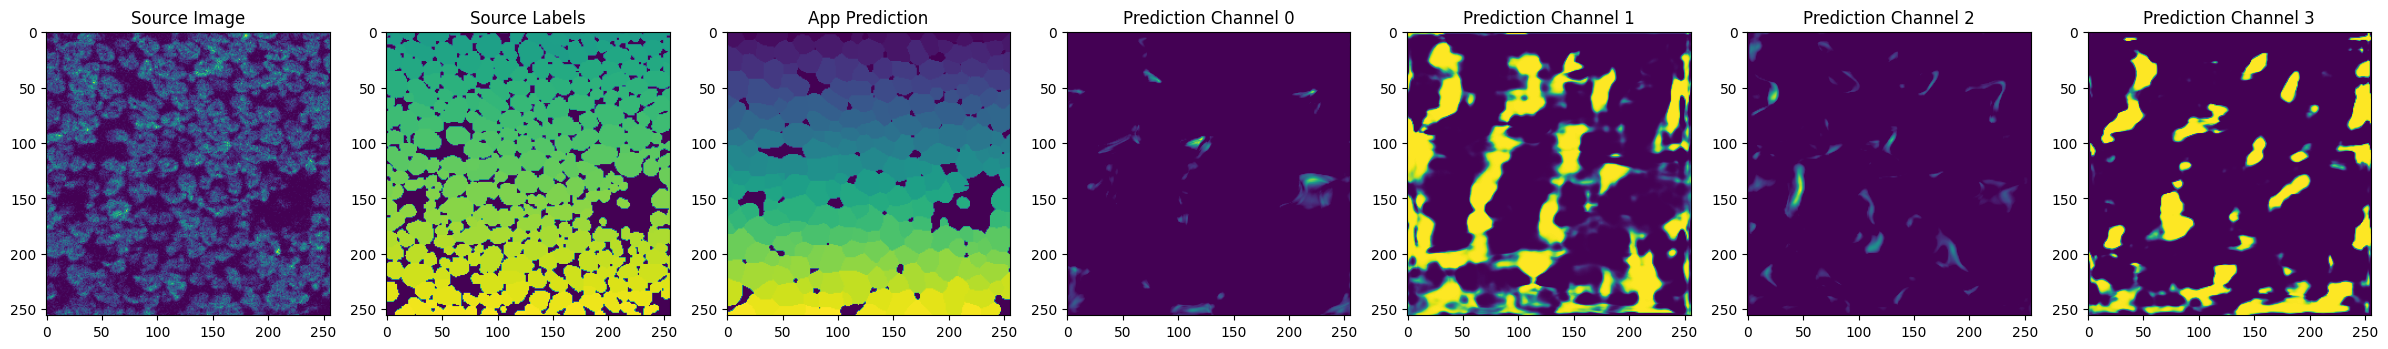

In [25]:
idx = 2
img, lab = X_test[idx].astype(np.float32), y_test[idx]
print(img.shape)

cell_pred = app.predict(np.expand_dims(img, axis=0),)
pred = cpu_model.predict(np.expand_dims(img, axis=0), batch_size=len(img))
fig, axes = plt.subplots(1, 7, figsize=(30, 15))

axes[0].imshow(img[..., 0])
axes[0].set_title('Source Image')

axes[1].imshow(lab[ ..., 0])
axes[1].set_title('Source Labels')

axes[2].imshow(cell_pred[0, ...])
axes[2].set_title('App Prediction')

axes[3].imshow(pred[0].cpu().detach().numpy()[0, ..., 0])
axes[3].set_title('Prediction Channel 0')

axes[4].imshow(pred[1].cpu().detach().numpy()[0, ..., 0])
axes[4].set_title('Prediction Channel 1')

axes[5].imshow(pred[2].cpu().detach().numpy()[0, ..., 0])
axes[5].set_title('Prediction Channel 2')

axes[6].imshow(pred[3].cpu().detach().numpy()[0, ..., 2])
axes[6].set_title('Prediction Channel 3')


plt.show()

In [26]:
cell_metrics = evaluate(cell_preds, y_test[..., :1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1324/1324 [01:29<00:00, 14.86it/s]
/usr/local/lib/python3.8/dist-packages/deepcell_toolbox/metrics.py:1098: UserWarning: Provided data is being relabeled. Cell ids from metrics will not match cell ids in original data. Relabel your data prior to running the metrics package if you wish to maintain cell ids. 
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/deepcell_toolbox/metrics.py:280: UserWarning: DICE score is technically 1.0, but prediction and truth arrays are empty.
  warnings.warn('DICE score is technically 1.0, '



____________Object-based statistics____________

Number of true cells:		 145225
Number of predicted cells:	 137052

Correct detections:  115584	Recall: 0.7959%
Incorrect detections: 21468	Precision: 0.8434%


Gained detections: 12834	Perc Error 34.1521%
Missed detections: 18183	Perc Error 48.3861%
Splits: 1729		Perc Error 4.601%
Merges: 3888		Perc Error 10.3462%
Catastrophes: 945		Perc Error 2.5147%
Gained detectionsfrom split: 1871
Missed detectionsfrom merge: 4413
True detectionsin catastrophe: 2373
Pred detectionsin catastrophe: 2091
SEG: 0.7963 

Average Pixel IOU (Jaccard Index): 0.8478 



/tmp/ipykernel_19964/35326704.py:10: RuntimeWarning: invalid value encountered in true_divide
  recall = metrics["correct_detections"].values / metrics["n_true"].values


In [27]:
# cell_metrics:
#   catastrophe: 824
#   f1: 0.7834164228098235
#   gained_detections: 15714
#   jaccard: 0.8252
#   merge: 3288
#   missed_detections: 20613
#   n_pred: 138995
#   n_true: 145225
#   precision: 0.8222
#   recall: 0.7869
#   split: 2256

In [34]:
nuc_preds = app.predict(X_test, compartment="nuclear")
nuc_metrics = evaluate(nuc_preds, y_test[..., 1:])

whole-cell
nuclear
{'maxima_threshold': 0.075, 'maxima_smooth': 0, 'interior_threshold': 0.2, 'interior_smooth': 2, 'small_objects_threshold': 15, 'fill_holes_threshold': 15, 'radius': 2}


/usr/local/lib/python3.8/dist-packages/skimage/_shared/utils.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1324/1324 [00:52<00:00, 25.24it/s]
/usr/local/lib/python3.8/dist-packages/deepcell_toolbox/metrics.py:1098: UserWarning: Provided data is being relabeled. Cell ids from metrics will not match cell ids in original data. Relabel your data prior to running the metrics package if you wish to maintain cell ids. 
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/deepcell_toolbox/metrics.py:280: UserWarning: DICE score is technically 1.0, but prediction and truth arrays are empty.
  warnings.warn('DICE score is technically 1.0, '



____________Object-based statistics____________

Number of true cells:		 135633
Number of predicted cells:	 128632

Correct detections:  116533	Recall: 0.8592%
Incorrect detections: 12099	Precision: 0.9059%


Gained detections: 6592	Perc Error 29.5685%
Missed detections: 11451	Perc Error 51.3636%
Splits: 968		Perc Error 4.342%
Merges: 2770		Perc Error 12.4249%
Catastrophes: 513		Perc Error 2.3011%
Gained detectionsfrom split: 1043
Missed detectionsfrom merge: 3105
True detectionsin catastrophe: 1319
Pred detectionsin catastrophe: 1239
SEG: 0.8108 

Average Pixel IOU (Jaccard Index): 0.8635 



/tmp/ipykernel_19964/35326704.py:10: RuntimeWarning: invalid value encountered in true_divide
  recall = metrics["correct_detections"].values / metrics["n_true"].values


In [28]:
inputs, labels = val_data.next()
cpu_model.eval()
cpu_app = Mesmer(cpu_model)
app_output = cpu_app.predict(inputs)


[print(labels[i].shape) for i in range(len(labels))]

img = inputs[0]
outputs = [i.cpu().detach().numpy() for i in cpu_model.predict(inputs, len(img))]

o_1 = outputs[0]
o_2 = outputs[1]
o_3 = outputs[2]
o_4 = outputs[3]

ch_1 = labels[0]
ch_2 = labels[1]
ch_3 = labels[2]
ch_4 = labels[3]



/usr/local/lib/python3.8/dist-packages/deepcell/utils/transform_utils.py:87: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  edge = binary_dilation(edge, selem=dil_strel)


whole-cell
nuclear
{'maxima_threshold': 0.075, 'maxima_smooth': 0, 'interior_threshold': 0.2, 'interior_smooth': 2, 'small_objects_threshold': 15, 'fill_holes_threshold': 15, 'radius': 2}
(8, 256, 256, 1)
(8, 256, 256, 3)
(8, 256, 256, 1)
(8, 256, 256, 3)


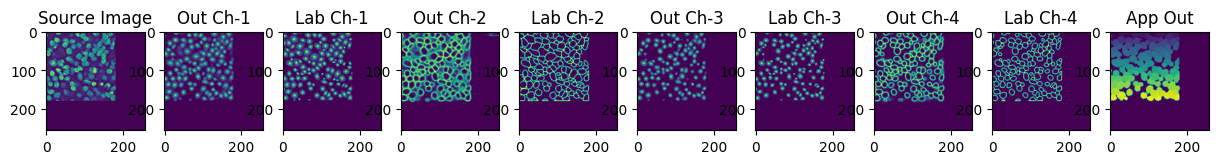

In [29]:
fig, axes = plt.subplots(1, 10, figsize=(15, 15))


axes[0].imshow(img[..., 0])
axes[0].set_title('Source Image')

axes[1].imshow(o_1[0, ..., 0])
axes[1].set_title('Out Ch-1')

axes[2].imshow(ch_1[0, ..., 0])
axes[2].set_title('Lab Ch-1')

axes[3].imshow(o_2[0, ..., 0])
axes[3].set_title('Out Ch-2')

axes[4].imshow(ch_2[0, ..., 0])
axes[4].set_title('Lab Ch-2')

axes[5].imshow(o_3[0, ..., 0])
axes[5].set_title('Out Ch-3')

axes[6].imshow(ch_3[0, ..., 0])
axes[6].set_title('Lab Ch-3')

axes[7].imshow(o_4[0, ..., 0])
axes[7].set_title('Out Ch-4')


axes[8].imshow(ch_4[0, ..., 0])
axes[8].set_title('Lab Ch-4')

axes[9].imshow(app_output[0, ..., 0])
axes[9].set_title('App Out')

plt.show()
